In [22]:
%matplotlib inline


Wav2Vec2를 이용해서 음성 인식하기
=============================

**저자**: `Moto Hira <moto@fb.com>`__

**번역**: `장보윤 <https://github.com/terri1102>`__

이 튜토리얼은 wav2vec 2.0으로 사전 학습된 모델을 이용해서 어떻게 음성 인식을 
수행하는지 안내합니다. [`논문 <https://arxiv.org/abs/2006.11477>`__]


개요
-----

음성인식은 아래와 같은 과정으로 진행됩니다.

1. 오디오 파형으로부터 음향 특성을 추출합니다.

2. 프레임별로 음향 특성의 클래스를 추정합니다.

3. 클래스 확률의 시퀀스에 따라서 가설을 설립합니다.

Torchaudio는 사전 학습된 모델 가중치와 기대 샘플링 레이트나 클래스 라벨과 같은 
관련 정보를 제공합니다. 이런 정보들은 
:py:func:`torchaudio.pipelines` 모듈에 포함되어 있습니다.




준비사항
-------

먼저 필요한 패키지들을 불러오고 사용할 데이터를 가져오겠습니다.




In [24]:
# %matplotlib inline

import os

import IPython
import matplotlib
import matplotlib.pyplot as plt
import requests
import torch
import torchaudio

matplotlib.rcParams["figure.figsize"] = [16.0, 4.8]

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(torch.__version__)
print(torchaudio.__version__)
print(device)

SPEECH_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"  # noqa: E501
SPEECH_FILE = "_assets/speech.wav"

if not os.path.exists(SPEECH_FILE):
    os.makedirs("_assets", exist_ok=True)
    with open(SPEECH_FILE, "wb") as file:
        file.write(requests.get(SPEECH_URL).content)

1.13.0+cu116
0.13.0+cu116
cuda


파이프라인 생성하기
----------------

먼저 특성 추출과 클래스 분류를 수행하는 Wav2Vec2 모델을 생성하겠습니다.

Torchaudio에는 사전 학습된 Wav2Vec2 모델 가중치가 두 종류 있습니다. 
하나는 ASR 태스크를 위해 미세 조정된 가중치이고 다른 하나는 미세 조정되지 않은 
가중치입니다.

Wav2Vec2 (그리고 HuBERT) 모델들은 자기 지도 방식으로 학습된 모델입니다. 이 모델들은 먼저
표현(representation)을 얻기 위해 오디오 데이터만으로 학습되었고, 
특정한 태스크를 위해 라벨을 추가하여 미세 조정되었습니다.

미세 조정되지 않은 사전 학습된 가중치는 다운스트림 태스크를 위해서 
미세 조정될 수 있지만 이번 튜토리얼에서는 이 부분에 대해 다루지는 않겠습니다.

이 튜토리얼에서 사용할 모델은 
:py:func:`torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H` 입니다.

이 외에도 :py:mod:`torchaudio.pipelines` 에는 다양한 모델들이 있습니다. 
모델 학습을 위한 세부 사항은 문서를 참고하시기 바랍니다.

아래의 코드에서 번들 객체(object)는 모델을 생성(instantiate)하고 다른 정보를 얻기 위한 
인터페이스를 제공합니다. 이를 이용해 샘플링 레이트와 클래스 라벨을 확인하겠습니다.




In [26]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
print(bundle)

print("Sample Rate:", bundle.sample_rate)

print("Labels:", bundle.get_labels())

Wav2Vec2ASRBundle(_path='wav2vec2_fairseq_base_ls960_asr_ls960.pth', _params={'extractor_mode': 'group_norm', 'extractor_conv_layer_config': [(512, 10, 5), (512, 3, 2), (512, 3, 2), (512, 3, 2), (512, 3, 2), (512, 2, 2), (512, 2, 2)], 'extractor_conv_bias': False, 'encoder_embed_dim': 768, 'encoder_projection_dropout': 0.1, 'encoder_pos_conv_kernel': 128, 'encoder_pos_conv_groups': 16, 'encoder_num_layers': 12, 'encoder_num_heads': 12, 'encoder_attention_dropout': 0.1, 'encoder_ff_interm_features': 3072, 'encoder_ff_interm_dropout': 0.0, 'encoder_dropout': 0.1, 'encoder_layer_norm_first': False, 'encoder_layer_drop': 0.05, 'aux_num_out': 29}, _sample_rate=16000, _labels=('|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z'), _remove_aux_axis=(1, 2, 3))
Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'"

모델은 아래와 같이 생성할 수 있습니다. 이 과정을 통해 사전 학습된 모델의 가중치를
가져와서 모델에 넣어줍니다.




In [27]:
model = bundle.get_model().to(device)

print(model.__class__)

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


데이터 불러오기
--------------

이번 튜토리얼에서는 Creative Commons 4.0 라이선스인 
`VOiCES 데이터셋 <https://iqtlabs.github.io/voices/>`__ 을 사용할 것입니다.




In [28]:
IPython.display.Audio(SPEECH_FILE)

데이터를 불러오기 위해 :py:func:`torchaudio.load` 를 사용합니다.

만약 데이터의 샘플링 레이트가 pipeline에서 기대하는 샘플링 레이트와 다른 경우 
:py:func:`torchaudio.functional.resample` 을 이용해서 리샘플링합니다.

<div class="alert alert-info"><h4>Note</h4><p>- :py:func:`torchaudio.functional.resample` 은 CUDA tensor에도 사용할 수 있습니다.
   - 같은 세트의 샘플링 레이트에 대해 여러 번 리샘플링을 수행할 경우, 
     :py:func:`torchaudio.transforms.Resample` 를 사용하면 성능이 더 개선될 수 있습니다.</p></div>




In [59]:
waveform, sample_rate = torchaudio.load(SPEECH_FILE)
print(waveform)
print(waveform.shape)
print(sample_rate)
print(waveform.shape[1]/sample_rate)

waveform = waveform.to(device)

if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

tensor([[0.0183, 0.0180, 0.0180,  ..., 0.0018, 0.0019, 0.0032]])
torch.Size([1, 54400])
16000
3.4


음향 특성 추출하기
----------------

다음으로 진행할 것은 오디오에서 음향 특성을 추출하는 것입니다.

<div class="alert alert-info"><h4>Note</h4><p>Wav2Vec2 모델은 ASR 태스크를 위해 미세 조정되어 특성 추출과 분류를 
   한 번에 수행할 수 있습니다.
   하지만 자세한 설명을 위해 이번 튜토리얼에서는 특성 추출을 하는 방법도 설명하겠습니다.</p></div>




In [36]:
with torch.inference_mode():
    features, _ = model.extract_features(waveform)

In [39]:
print(len(features))
for feature in features:
    print(feature.shape)

12
torch.Size([1, 169, 768])
torch.Size([1, 169, 768])
torch.Size([1, 169, 768])
torch.Size([1, 169, 768])
torch.Size([1, 169, 768])
torch.Size([1, 169, 768])
torch.Size([1, 169, 768])
torch.Size([1, 169, 768])
torch.Size([1, 169, 768])
torch.Size([1, 169, 768])
torch.Size([1, 169, 768])
torch.Size([1, 169, 768])


반환되는 특성은 tensor의 배열이고 각 tensor는 transformer 레이어의 출력입니다.




In [40]:
fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu())
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

특성 분류하기
------------

음향 특성을 추출한 후 다음 단계는 특성을 카테고리로 분류하는 것입니다.

Wav2Vec2 모델은 특성 추출과 분류를 한 번에 수행합니다.




In [41]:
with torch.inference_mode():
    emission, _ = model(waveform)

In [43]:
print(emission.shape)
print(emission[0,0,:])

torch.Size([1, 169, 29])
tensor([15.2341, -1.8694, -3.2888, -2.2687, -3.5227, -3.5009, -1.8024, -2.5781,
        -3.6600, -2.5399, -3.5117, -3.3206, -2.4473, -1.6049, -2.6318, -3.8108,
        -5.5422, -6.2940, -5.6236, -2.8636, -4.3628, -2.6739, -5.5819, -5.9805,
        -8.7514, -8.8683, -6.7983, -6.9670, -7.4787], device='cuda:0')


결과는 확률의 형태가 아닌 로짓(logit)의 형태로 나옵니다.

이를 시각화해 보겠습니다.




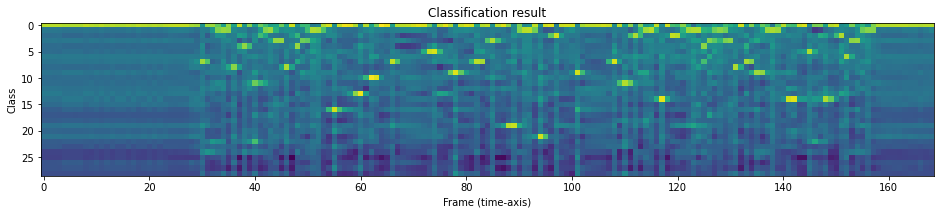

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [44]:
plt.imshow(emission[0].cpu().T)
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.show()
print("Class labels:", bundle.get_labels())

타임 라인에 따라 특정한 라벨이 강하게 나타나는 것을 알 수 있습니다.




In [50]:
for pred in emission[0]:
    # print(pred.shape)
    i = pred.argmax()
    print(bundle.get_labels()[i], end="")

------------------------------I--||-H-A-D-||TTH-ATT||--C----U-RR--I------OO---S---I--T--YY|||-B--E---S------I-D-E-||-M-EE-|||AT||TTH-I-SS|||-MM--O--M--ENTT|||-----------

대본(transcript) 생성하기
------------------------

이제 라벨 확률의 시퀀스에서 대본(transcript)을 생성할 차례입니다. 이렇게 가설을 
생성하는 과정을 "디코딩"이라고 부릅니다.

디코딩은 단순한 분류보다는 더 정교한 작업입니다. 
특정 타임 스텝에서 디코딩을 하는 것은 주변 관측에 영향을 받을 수 있기 때문입니다.

예를 들어 ``night`` 와 ``knight`` 의 경우를 생각해 보겠습니다. ``night`` 와 
``knight`` 의 사전 확률 분포가 다르더라도 
(일반적인 대화에서 ``night`` 가 ``knight`` 보다 훨씬 더 자주 등장합니다) 
``a knight with a sword`` 와 같은 문장에서 ``knight`` 로 정확한 대본을 생성하기 
위해서는 디코딩 과정에서 충분한 문맥을 볼 때까지 최종 결정을 연기해야 합니다.

디코딩을 위한 다양한 기술들은 많은 경우 
단어 사전과 언어 모델과 같은 외부 리소스를 요구합니다.

이번 튜토리얼에서는 단순함을 위해 탐욕적인(greedy) 디코딩을 사용하여 외부 요소에 
의존하지 않고 각 타임 스텝에서 가장 좋은 가설을 선택하겠습니다. 
따라서 문맥 정보는 사용되지 않고 하나의 대본만 생성됩니다.

탐욕적인 디코딩 알고리즘을 정의하겠습니다.




In [19]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

디코더 객체를 생성하고, 대본을 디코딩합니다.




In [51]:
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])

이제 결과를 확인하고 오디오를 다시 들어 보겠습니다.




In [52]:
print(transcript)
IPython.display.Audio(SPEECH_FILE)

I|HAD|THAT|CURIOSITY|BESIDE|ME|AT|THIS|MOMENT|


In [53]:
test_dataset = torchaudio.datasets.LIBRISPEECH("./", url="test-clean", download=True)

  0%|          | 0.00/331M [00:00<?, ?B/s]

In [54]:
test_dataset[1]

(tensor([[ 0.0010,  0.0011,  0.0009,  ..., -0.0007, -0.0010, -0.0011]]),
 16000,
 'STUFF IT INTO YOU HIS BELLY COUNSELLED HIM',
 1089,
 134686,
 1)

In [66]:
index=4
waveform = test_dataset[index][0]
y_script = test_dataset[index][2]

waveform = waveform.to(device)

with torch.inference_mode():
    emission, _ = model(waveform)

decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])

print("정답:", y_script)
print("예측:", transcript)
IPython.display.Audio(waveform.cpu(), rate=16000)

정답: NUMBER TEN FRESH NELLY IS WAITING ON YOU GOOD NIGHT HUSBAND
예측: NUMBER|TEN|FRESH|NELLY|IS|WAITING|ON|YOU|GOOD|NIGHT|HUSBAND|


ASR 모델은 Connectionist Temporal Classification (CTC)이라는 손실 함수를 
사용하여 미세 조정됩니다. CTC 손실 함수의 세부 사항은 
`여기 <https://distill.pub/2017/ctc/>`__ 를 참고하시기 바랍니다.
CTC에서 공백 토큰 (ϵ)은 기존 심볼의 반복을 나타내는 스페셜 토큰입니다. 
디코딩 과정에서 공백 토큰은 무시됩니다.




결론
----

이번 튜토리얼에서 음향 특성 추출과 음성 인식을 위해서 
:py:mod:`torchaudio.pipelines` 를 어떻게 사용하는지 알아보았습니다. 
모델을 만들고 산출물(emission)을 얻는 모든 과정은 아래의 2줄 만으로도 가능합니다.

::

   model = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H.get_model()
   emission = model(waveforms, ...)


